In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [94]:
from collections import defaultdict, Counter
import pickle
from pathlib import Path

import datasets
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange
import transformers

from src.datasets.speech_equivalence import \
    SpeechEquivalenceDataset, SpeechHiddenStateDataset, make_timit_equivalence_dataset
from src.models.integrator import ContrastiveEmbeddingModel, ContrastiveEmbeddingModelConfig, prepare_dataset
from src.utils.timit import load_or_prepare_timit_corpus

In [95]:
model_name = "facebook/wav2vec2-base"

equivalence_classer = "phoneme"
num_frames_per_phoneme = 1

layer = 6
output_dim = 32

equiv_dataset_path = f"data/timit_equiv_{equivalence_classer}_{layer}_{num_frames_per_phoneme}.pkl"
output_dir = f"out/ce_model_random_{output_dim}"

In [96]:
model: transformers.Wav2Vec2Model = transformers.Wav2Vec2Model.from_pretrained(model_name)

/home/jgauthie/om2/miniconda/envs/ideal/lib/python3.10/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
if Path(equiv_dataset_path).exists():
    with open(equiv_dataset_path, "rb") as f:
        equiv_dataset = pickle.load(f)
else:
    assert False, "produce equiv dataset first by training a real model"

In [98]:
equiv_dataset

SpeechEquivalenceDataset(timit_phoneme/phoneme, 40 classes, 147135 instances, with SpeechHiddenStateDataset(facebook/wav2vec2-base, 4620 items, 706150 frames, 1 layers, 768 hidden size))

26

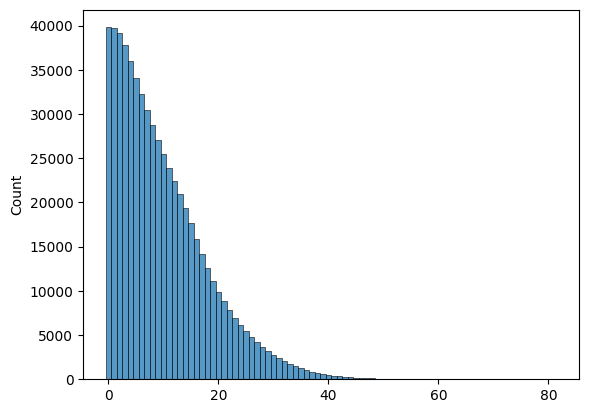

In [99]:
# Pick a max length that accommodates the majority of the samples, excluding outlier lengths
evident_lengths = equiv_dataset.lengths
evident_lengths = evident_lengths[evident_lengths != -1]
target_length = int(torch.quantile(evident_lengths.double(), 0.95).item())
sns.histplot(evident_lengths.numpy(), discrete=True)
target_length

## Prepare model

In [100]:
ce_model_config = ContrastiveEmbeddingModelConfig(
    base_model_ref=model_name,
    base_model_layer=layer,

    equivalence_classer=equivalence_classer,

    max_length=target_length,
    input_dim=equiv_dataset.hidden_state_dataset.hidden_size,
    hidden_dim=32,
    output_dim=output_dim,
    tau=0.1)


In [101]:
ce_model = ContrastiveEmbeddingModel(ce_model_config)

In [102]:
training_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    save_steps=100,
    eval_steps=100,
    save_total_limit=5,
    logging_steps=10,
    logging_dir=f"{output_dir}/logs",
    evaluation_strategy="steps",
    logging_first_step=True,
    load_best_model_at_end=True,
    greater_is_better=False,
    remove_unused_columns=False,
    save_safetensors=False,

    learning_rate=1e-3,
)

# dataset_split = ce_dataset.train_test_split(test_size=0.05, shuffle=True)
# train_dataset = dataset_split["train"]
# eval_dataset = dataset_split["test"]
trainer = transformers.Trainer(
    model=ce_model,
    # train_dataset=train_dataset,
    # eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    # data_collator=MyCollator(max_length),
    args=training_args)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [103]:
checkpoint_dir = Path(output_dir) / "checkpoint-0"
checkpoint_dir.mkdir(exist_ok=True, parents=True)
trainer.save_model(Path(output_dir) / "checkpoint-0")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 26}


In [104]:
# Save dummy trainer state
trainer.state.best_model_checkpoint = str(checkpoint_dir)
trainer.state.save_to_json(checkpoint_dir / "trainer_state.json")